In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Расчет числа сообществ и модулярности

         week  communities  modularity
0  2022-01-24           91       0.793
1  2022-01-31          106       0.677
2  2022-02-07           76       0.683
3  2022-02-14          110       0.675
4  2022-02-21           93       0.687


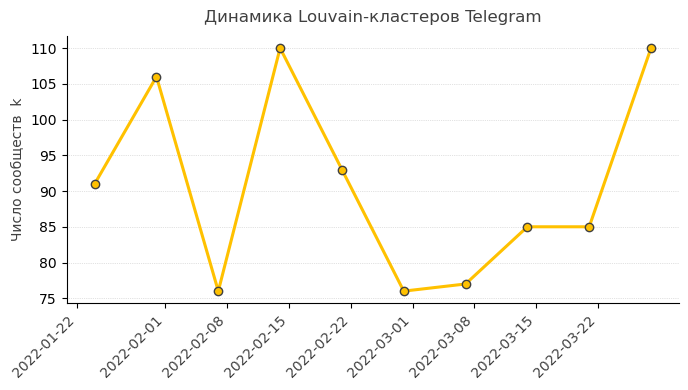

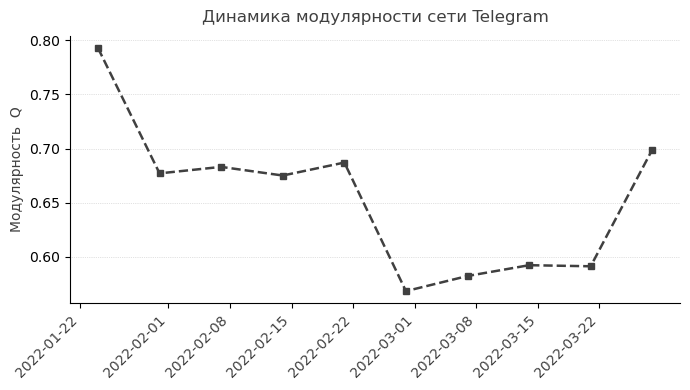

In [ ]:
import pandas as pd
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1.  Считываем данные
# ------------------------------------------------------------

df = (pd.read_csv('final_data.csv')
        .drop(columns=['Unnamed: 0'], errors='ignore'))

df['time']   = pd.to_datetime(df['time'], utc=True)
df_rep = df[df['sourse'].notna()]

# ------------------------------------------------------------
# 2.  Группируем рёбра по неделям (Пн–Вс)
# ------------------------------------------------------------
edges_w = (df_rep
           .groupby(['sourse', 'name', pd.Grouper(key='time', freq='W-MON')])
           .size()
           .reset_index(name='weight')
           .rename(columns={'time': 'week',
                            'sourse': 'source',
                            'name':   'target'}))

# ------------------------------------------------------------
# 3.  Считаем Louvain-кластеры и модулярность
# ------------------------------------------------------------
records = []

for ts, chunk in edges_w.groupby('week', sort=True):
    # строим неориентированный граф с весами
    G = nx.from_pandas_edgelist(chunk,
                                source='source',
                                target='target',
                                edge_attr='weight',
                                create_using=nx.Graph())

    if len(G) < 2:
        continue

    part     = community_louvain.best_partition(G, weight='weight', random_state=42)
    k        = len(set(part.values()))
    Q        = community_louvain.modularity(part, G, weight='weight')

    records.append({'week': ts.date(), 'communities': k, 'modularity': round(Q, 3)})

results = pd.DataFrame(records).sort_values('week')
results.to_csv('communities_by_week.csv', index=False)

print(results.head())

# ------------------------------------------------------------
# 4.  ОТДЕЛЬНЫЕ ГРАФИКИ: k и Q
# ------------------------------------------------------------

## 4a. Число сообществ  k  ###################################
plt.figure(figsize=(7, 4), facecolor="white")

plt.plot(results['week'], results['communities'],
         color="#ffc100", marker="o", markersize=6,
         markeredgecolor="#404040", linewidth=2.2)

plt.ylabel("Число сообществ  k", color="#404040")
plt.title("Динамика Louvain-кластеров Telegram", color="#404040", pad=10)

plt.xticks(rotation=45, ha="right", color="#404040")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle=":", linewidth=0.5, color="#404040", alpha=0.3)

plt.tight_layout()
plt.savefig("communities_trend_k.png", dpi=300, facecolor="white")
plt.show()

## 4b. Модулярность  Q  ######################################
plt.figure(figsize=(7, 4), facecolor="white")

plt.plot(results['week'], results['modularity'],
         color="#404040", linestyle="--", marker="s", markersize=5,
         markeredgecolor="#404040", linewidth=1.8)

plt.ylabel("Модулярность  Q", color="#404040")
plt.title("Динамика модулярности сети Telegram", color="#404040", pad=10)

plt.xticks(rotation=45, ha="right", color="#404040")
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle=":", linewidth=0.5, color="#404040", alpha=0.3)

plt.tight_layout()
plt.savefig("communities_trend_Q.png", dpi=300, facecolor="white")
plt.show()


# Расчет статистик по датасету

In [ ]:
df = pd.read_csv('final_data.csv')
df

,Unnamed: 0.1,Unnamed: 0,name,time,content,sourse,link,SVO,sentiment,topic
0,0,0,SBelkovskiy,2022-02-24 00:15:21+00:00,Вот и обыски на Москве обычно начинаются где-т...,news_echo,['https://t.me/news_echo/10813'],1,Positive,консервативная
1,1,1,yuzhnocity,2022-02-24 00:46:12+00:00,Во время эвакуации нужно было забирать самое н...,breakingmash,['https://t.me/breakingmash/31480'],1,Positive,консервативная
2,2,2,madam_secretar,2022-02-24 00:49:02+00:00,"Лягут как лёгкая бригада. Или побегут, задрав ...",vesparevenge,['https://t.me/madam_secretar/6694'],1,Positive,консервативная
3,3,3,madam_secretar,2022-02-24 00:49:02+00:00,"Лягут как лёгкая бригада. Или побегут, задрав ...",madam_secretar,['https://t.me/madam_secretar/6694'],1,Positive,консервативная
4,4,4,andyhukka_live,2022-02-24 00:50:32+00:00,Вторжение должно начаться с довольно длительно...,rusbrief,['https://t.me/mozhemobyasnit/11339'],1,Positive,консервативная
...,...,...,...,...,...,...,...,...,...,...
106909,106909,106909,dtlive,2022-02-22 23:13:22+00:00,Знаю автора несколько лет. Василий был гостем ...,mihalych67,['https://t.me/ukr_leaks/1377'],0,Positive,консервативная
106910,106910,106910,dtlive,2022-02-22 23:13:22+00:00,Знаю автора несколько лет. Василий был гостем ...,ukr_leaks,['https://t.me/ukr_leaks/1377'],0,Positive,консервативная
106911,106911,106911,dtlive,2022-02-22 23:32:05+00:00,«И бесплатно отряд поскакал на врага…» (с)Из п...,OpenUkraine,['https://t.me/OpenUkraine/6120'],0,Negative,консервативная
106912,106912,106912,dtlive,2022-02-22 23:51:48+00:00,"А вот тут уже 400 депутатовТак что, расширять ...",vv_volodin,['https://t.me/vv_volodin/312'],0,Positive,коммунистическая


In [ ]:
df["period"]   = df["SVO"].map({0: "до СВО", 1: "после СВО"})
df["is_repost"] = df["sourse"].notna() & (df["sourse"] != "")

# 3. Сводная таблица: сообщения, каналы, % репостов
summary = (
    df.groupby("period")
      .agg(
          Сообщений      = ("content", "size"),
          Каналов         = ("name", "nunique"),
          Проц_репостов   = ("is_repost", lambda x: round(100 * x.mean(), 1))
      )
      .reset_index()
)

# 4. Сохраняем в TeX, чтобы сразу вставить в диплом
summary.to_latex("table1_description.tex", index=False, decimal=",")

# 5. Показываем результат в ноутбуке
summary

,period,Сообщений,Каналов,Проц_репостов
0,до СВО,47092,1244,100.0
1,после СВО,59822,1728,100.0


In [ ]:
date_bounds = (
    df.groupby("period")["time"]
      .agg(Начало="min", Конец="max")
      .reset_index()
)
date_bounds

,period,Начало,Конец
0,до СВО,2022-01-23 00:07:01+00:00,2022-02-22 23:54:32+00:00
1,после СВО,2022-02-24 00:15:21+00:00,2022-03-23 23:56:16+00:00


# Расчет изменений тональности

χ² = 577.92 (df=2),  p-value = 3.2081e-126


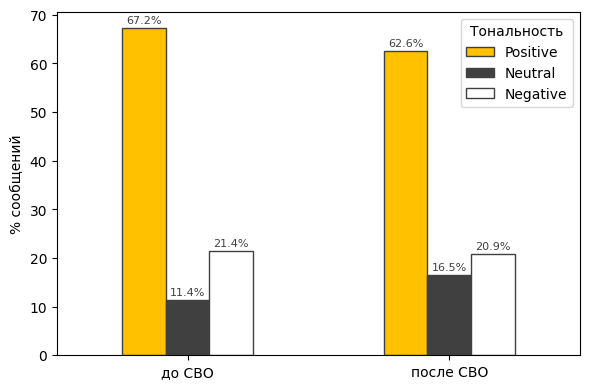

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# ---- 1. перекрёстная таблица (Absolute counts) ----
sent_crosstab = (
    df.groupby(["period", "sentiment"])
      .size()
      .unstack(fill_value=0)          # строки: период, колонки: Positive / Neutral / Negative
)

# ---- 2. доли в процентах ----
sent_pct = (sent_crosstab
            .div(sent_crosstab.sum(axis=1), axis=0)
            .round(4) * 100)

# ---- 3. χ²-тест ----
chi2, pval, dof, expected = chi2_contingency(sent_crosstab.values)
print(f"χ² = {chi2:.2f} (df={dof}),  p-value = {pval:.4e}")

# ---- 4. сохраняем TeX-таблицу ----
sent_pct.to_latex("table2_sentiment.tex",
                  index=True,               # сохраняем метку периода
                  float_format="%.1f",
                  caption="Распределение тональности сообщений по периодам, %")

# ---- 5. столбчатый график ----
palette = ["#ffc100", "#404040", "#ffffff"]        # Positive, Neutral, Negative
ax = (
    sent_pct[["Positive", "Neutral", "Negative"]]
        .plot(kind="bar",
              figsize=(6, 4),
              rot=0,
              color=palette,
              edgecolor="#404040")                 # тёмный контур для читаемости «белых» столбцов
)

ax.set_ylabel("% сообщений")
ax.set_xlabel("")          # убираем подпись «period»
ax.legend(title="Тональность")

# --- подписи процентов ---
for container in ax.containers:                    # по одной «группе» баров
    ax.bar_label(container,
                 labels=[f"{v:.1f}%" for v in container.datavalues],
                 label_type="edge",
                 padding=2,
                 fontsize=8,
                 color="#404040")

plt.tight_layout()
plt.savefig("fig_sentiment.png", dpi=300)
plt.show()


# Расчет изменений идеологии

χ² = 448.40 (df=2), p-value = 4.2877e-98


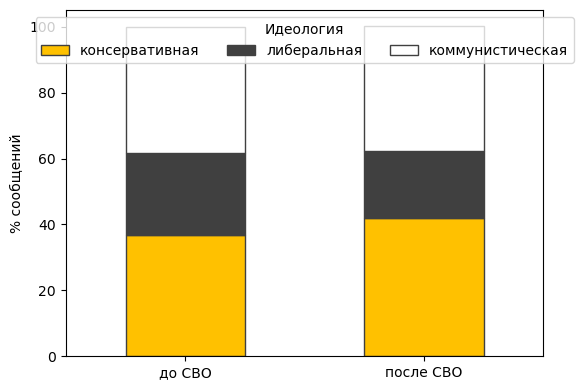

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# --- кросстаб идеологий ---
ideo_crosstab = (
    df.groupby(["period", "topic"])
      .size()
      .unstack(fill_value=0)        # строки: период, столбцы: идеологии
)

# проценты
ideo_pct = (ideo_crosstab
            .div(ideo_crosstab.sum(axis=1), axis=0)
            * 100).round(1)

# χ²-тест
chi2_i, p_i, dof_i, _ = chi2_contingency(ideo_crosstab.values)
print(f"χ² = {chi2_i:.2f} (df={dof_i}), p-value = {p_i:.4e}")


# ---- 5. график «Идеологии» ----
# Фирменная палитра: золото → тёмно-серый → белый
color_map = {
    "консервативная": "#ffc100",
    "либеральная":    "#404040",
    "коммунистическая": "#ffffff"
}

# Переставим колонки в нужном порядке
order = ["консервативная", "либеральная", "коммунистическая"]
ideo_pct = ideo_pct[order]

ax = ideo_pct.plot(kind="bar",
                   stacked=True,
                   color=[color_map[c] for c in order],
                   edgecolor="#404040",       # рамка, чтобы белый сегмент был виден
                   figsize=(6, 4),
                   rot=0)

ax.set_ylabel("% сообщений")
ax.set_xlabel("")
ax.legend(title="Идеология", loc="upper center", ncol=3)


plt.tight_layout()
plt.savefig("fig_ideology.png", dpi=300)
plt.show()


In [ ]:
ideo_pct

topic,коммунистическая,консервативная,либеральная
period,,,
до СВО,38.2,36.8,24.9
после СВО,37.9,42.0,20.2
